In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from src.bioreactor import *

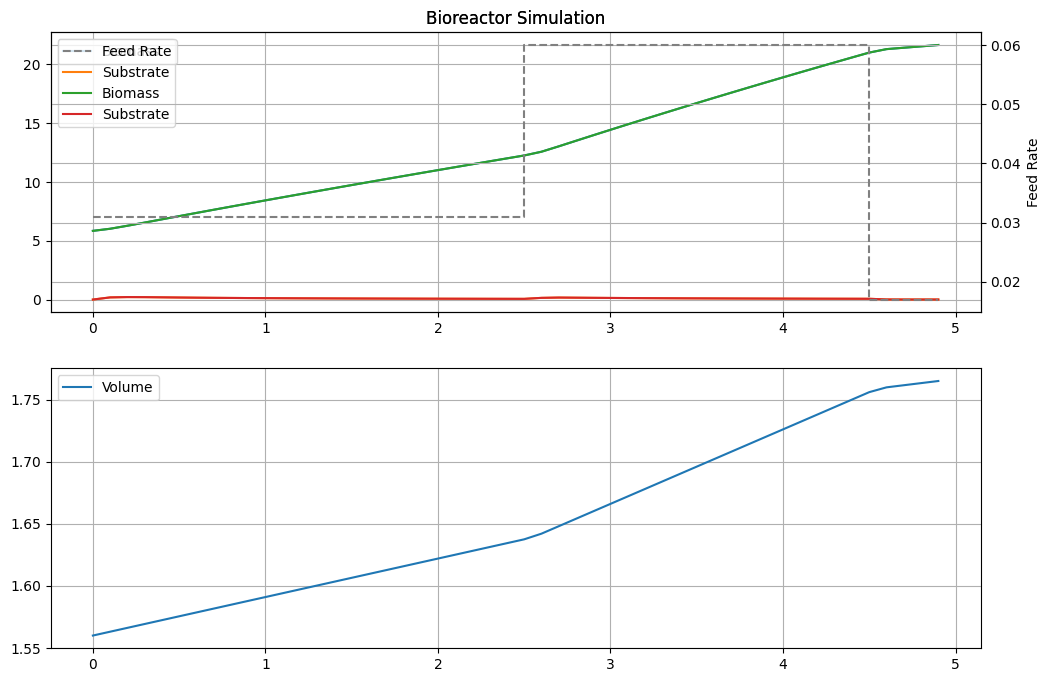

In [22]:
# inlet flowrate
def Fs(t):
    if t <= 2.5:
        return 0.031
    elif t <= 4.5:
        return 0.060
    elif t <= 4:
        return 0.031
    else:
        return 0.017

sol = simulate(Fs)

In [23]:
# X_train, y_train = generate_training_data()

# model = MLPRegressor(hidden_layer_sizes=(256, 256)).fit(X_train, y_train)

In [24]:
# model = torch.load('./models/pinc_trained_v2.pth')

In [25]:
X, S, V, F = mpc(model='discretized')
# X, S, V, F = mpc_pso(model)
# X, S, V, F = mpc_diff_evol(model)
# X, S, V, F = mpc(model)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 17.35it/s]


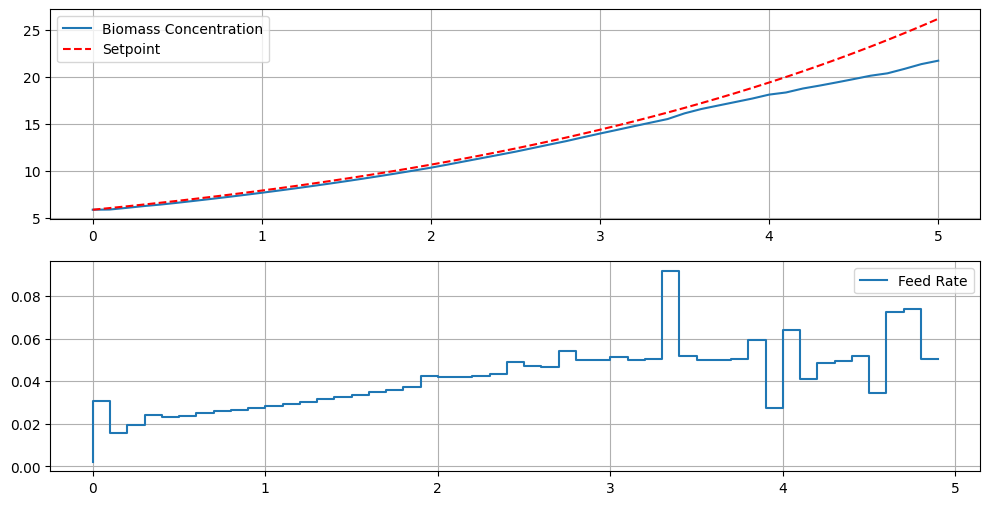

In [26]:
plot_results(X, F)

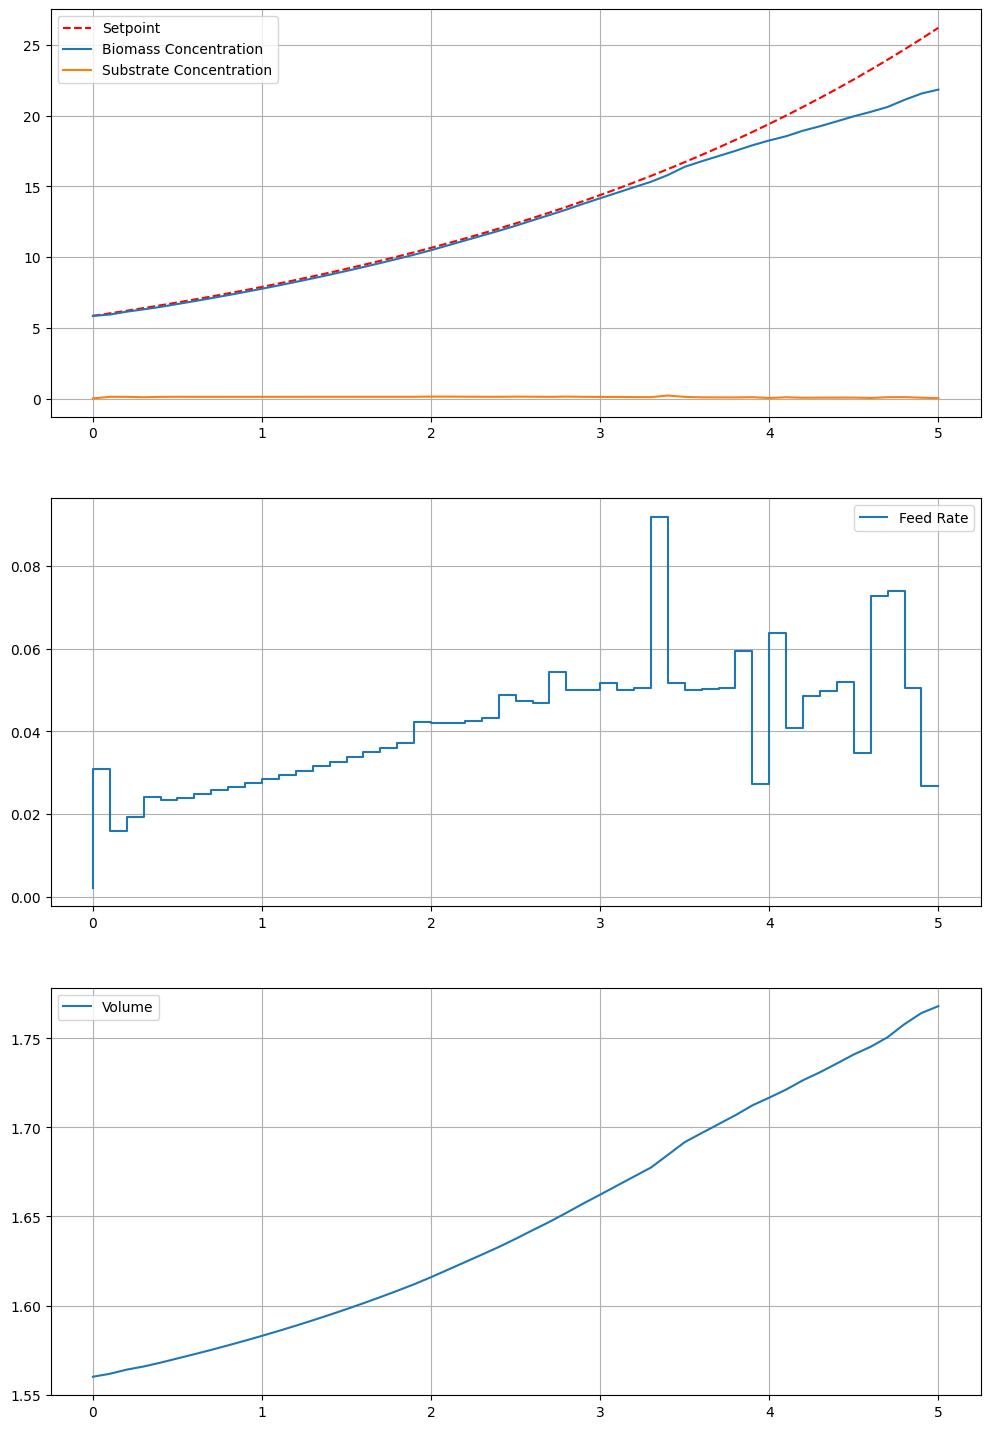

In [31]:
evaluation(F)